# Parte 1: Extracción de datos a través de Web Scrapping

## Importar las librerias con las que trabajaremos

In [19]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import csv
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Extraer la fecha actual para la recopilación de los datos

In [46]:

hoy = datetime.today()
fecha_inicio = hoy - timedelta(days=7)
todos_sismos = []
print(hoy)

2025-11-04 18:51:54.296382


- Con esto podemos saber la fecha actual y lo mas importante, el dia en el que estamos, este dato lo utilizaremos para poder extraer los datos de cada dia que queramos de la página web a la que haremos web scrapping

## Creación de estructura repetitiva para la extracción de los datos


In [47]:
for i in range(7):  # Recorre los últimos dias i, si queremos extraer más días, cambiar el rango, 7 para tener datos rapidamente
    fecha = hoy - timedelta(days=i)
    url = f"https://www.sismologia.cl/sismicidad/catalogo/{fecha.year}/{fecha.month:02d}/{fecha.strftime('%Y%m%d')}.html"
    print(f"Extrayendo: {url}")

    resp = requests.get(url)
    if resp.status_code != 200:
        print(f"No se pudo acceder a {url}")
        continue

    soup = BeautifulSoup(resp.text, "html.parser")
    tabla = soup.find("table", class_="sismologia detalle")
    if not tabla:
        print(f"No se encontró tabla para {fecha}")
        continue

    filas = tabla.find_all("tr")[1:] 

    for fila in filas:
        celdas = fila.find_all("td")
        if len(celdas) < 5:
            continue

        fecha_local = celdas[0].get_text(strip=True)
        fecha_utc = celdas[1].get_text(strip=True)
        lat_long_raw = celdas[2].get_text(strip=True)
        lat_long = [x for x in lat_long_raw.replace('\n', ' ').split(' ') if x]
        latitud = lat_long[0] if len(lat_long) > 0 else ""
        longitud = lat_long[1] if len(lat_long) > 1 else ""
        profundidad = celdas[3].get_text(strip=True)
        magnitud = celdas[4].get_text(strip=True)

        todos_sismos.append({
            "fecha_local": fecha_local,
            "fecha_utc": fecha_utc,
            "latitud": latitud,
            "longitud": longitud,
            "profundidad": profundidad,
            "magnitud": magnitud
        })
    time.sleep(1)

Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/11/20251104.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/11/20251103.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/11/20251102.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/11/20251101.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251031.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251030.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251029.html


- De esta extracción obtenemos los siguientes datos. 
1. La fecha local del sismo.
2. El tiempo universal coordinado o UTC
3. La latitud del sismo
4. La longitud del sismo
5. La profundidad del sismo
6. La magnitud de este.
- Con estos datos podemos obtener mucha información respecto a los sismos en Chile, podemos clasificar las regiones por sismos, la cantidad de estos, la potencia (leve, moderada, grave), etc.

## Guardar los datos en almacenados en un CSV

In [48]:

df_sismos = pd.DataFrame(todos_sismos)
df_sismos.to_csv("sismos.csv", index=False, encoding="utf-8")
print(f"Guardado en: sismos.csv")

Guardado en: sismos.csv


- Con esto guardamos toda la información en un CSV, sin embargo al guardar de forma directa se generan errores, por lo que en la siguiente sección nos encargaremos de la correción y limpieza se errores.

# Parte 2: Correción de errores

## Leer el csv con pandas

In [28]:
df = pd.read_csv("sismos.csv", encoding="utf-8")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha_local  168 non-null    object 
 1   fecha_utc    168 non-null    object 
 2   latitud      168 non-null    object 
 3   longitud     0 non-null      float64
 4   profundidad  168 non-null    object 
 5   magnitud     168 non-null    object 
dtypes: float64(1), object(5)
memory usage: 8.0+ KB
None


- Con esta información nos damos cuenta de que la latitud y la longitud se almacenan en la misma variable, debido a que no se separan en la página web

## Arreglar latitud y longitud

In [25]:
for i, fila in df.iterrows():
    if pd.isna(fila["longitud"]) or str(fila["longitud"]).strip() == "":
        latlong = str(fila["latitud"]).strip()
        if "-" in latlong[1:]:  # evitar el primer signo negativo
            partes = latlong[1:].split("-", 1)
            if len(partes) == 2:
                df.at[i, "latitud"] = latlong[0] + partes[0]
                df.at[i, "longitud"] = "-" + partes[1]
print(df.head())

                                         fecha_local            fecha_utc  \
0          2025-10-19 18:52:5961 km al SE de Socaire  2025-10-19 21:52:59   
1         2025-10-19 16:35:5139 km al SO de OllagÃ¼e  2025-10-19 19:35:51   
2  2025-10-19 15:50:3741 km al O de San Pedro de ...  2025-10-19 18:50:37   
3            2025-10-19 14:22:5546 km al N de Calama  2025-10-19 17:22:55   
4          2025-10-19 14:06:3424 km al O de OllagÃ¼e  2025-10-19 17:06:34   

   latitud longitud profundidad magnitud  
0  -24.038  -67.550      245 km   2.9 Ml  
1  -21.540  -68.423      129 km   3.1 Ml  
2  -22.832  -68.587      113 km   2.7 Ml  
3  -22.084  -68.783      100 km   3.1 Ml  
4  -21.196  -68.479      133 km   2.7 Ml  


C:\Users\pcx\AppData\Local\Temp\ipykernel_3672\3256924476.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-67.550' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, "longitud"] = "-" + partes[1]


- Con esta correción podemos separar las latitudes y longitudes, solo falta guardarlos, en este caso, en un nuevo CSV llamado BDD

## Guardar datos en un csv

In [26]:
df.to_csv("bdd.csv", index=False, encoding="utf-8")

print(f"Archivo corregido guardado como: bdd.csv")

Archivo corregido guardado como: bdd.csv


- Ahora podremos tener todos los datos guardados correctamente y sin fallos, pero se nos presenta un nuevo problema, si nos fijamos en la magnitud, esta no es un numero, si no que un numero mas el tipo de dato (Ml)

## Convertir magnitudes a decimales

In [17]:
df['magnitud'] = (
    df['magnitud']
    .astype(str)
    .str.extract(r'([\d,.]+)')
    .replace(',', '.', regex=True)
    .astype(float)
)
print(df['magnitud'].head())

0    2.9
1    3.1
2    2.7
3    3.1
4    2.7
Name: magnitud, dtype: float64


- Con esto tenemos todas las magnitudes transformadas a float como se indica en dtype

## Solucionar problemas de tipo de dato con longitud

In [20]:
latitudes = []
longitudes = []

for i, fila in df.iterrows():
    lat_s = str(fila["latitud"]) if not pd.isna(fila["latitud"]) else ""
    lon_s = str(fila["longitud"]) if not pd.isna(fila["longitud"]) else ""

    if lon_s.strip() == "" or lon_s.lower() in ("nan", "none"):
        nums = re.findall(r'-?\d+(?:\.\d+)?', lat_s)
        if len(nums) >= 2:
            latitudes.append(nums[0])
            longitudes.append(nums[1])
            continue

    lat_num = re.search(r'-?\d+(?:\.\d+)?', lat_s)
    lon_num = re.search(r'-?\d+(?:\.\d+)?', lon_s)
    latitudes.append(lat_num.group(0) if lat_num else None)
    longitudes.append(lon_num.group(0) if lon_num else None)

df["latitud"] = pd.to_numeric(latitudes, errors="coerce")
df["longitud"] = pd.to_numeric(longitudes, errors="coerce")

print(df[["latitud", "longitud"]].dtypes)
print(df[["latitud", "longitud"]].head())

latitud     float64
longitud    float64
dtype: object
   latitud  longitud
0  -24.038   -67.550
1  -21.540   -68.423
2  -22.832   -68.587
3  -22.084   -68.783
4  -21.196   -68.479


- Con esto nos facilitamos el manejo de estos datos, para la siguiente parte, que es usar los datos para tener información útil que podamos mostrar

# Parte 3: Creación de nuevos datos

- Con los datos obtenidos, podemos crear información nueva que nos sirva para el análisis de datos, en este caso, crearemos tres nuevas columnas región para indicar la región en la que se produjo el sismo (de forma aproximada), enlace a google maps (para que al hacer click, dirija instanteneamente al punto exacto donde se produjo el sismo) y rango profundidad (para la manipulación de datos mas intuitiva y entendible)

## Ubicar aproximadamente los sismos en una región

In [21]:
# Rangos de latitud para cada región (al chile ser un país largo en latitud, podemos usar esto para asignar regiones aproximadas)
rangos_regiones = [
    (-19.000, -17.300, "Arica y Parinacota"),
    (-21.300, -19.000, "Tarapacá"),
    (-25.300, -21.300, "Antofagasta"),
    (-29.300, -25.300, "Atacama"),
    (-32.000, -29.300, "Coquimbo"),
    (-32.950, -32.000, "Valparaíso"),
    (-34.150, -32.950, "Región Metropolitana de Santiago"),
    (-35.000, -34.150, "Libertador B. O'Higgins"),
    (-36.250, -35.000, "Maule"),
    (-36.850, -36.250, "Ñuble"),
    (-37.900, -36.850, "Biobío"),
    (-40.500, -37.900, "La Araucanía"),
    (-40.580, -39.500, "Los Ríos"),
    (-43.600, -40.580, "Los Lagos"),
    (-48.000, -43.600, "Aysén del General Carlos Ibáñez del Campo"),
    (-52.810, -48.000, "Magallanes y de la Antártica Chilena")
]
# Guardar las regiones en una variable
regiones = []

for lat in df["latitud"]:
    region_encontrada = "Fuera de Chile"
    for lat_min, lat_max, region in rangos_regiones:
        if lat_min <= lat <= lat_max:
            region_encontrada = region
            break
    regiones.append(region_encontrada)

df["region"] = regiones
print(df["region"].head())
print(len(df))


0    Antofagasta
1    Antofagasta
2    Antofagasta
3    Antofagasta
4       Tarapacá
Name: region, dtype: object
168


- Con esto ya tenemos asignadas regiones a cada uno de los sismos, pero el centro sismológico nacional también detecta sismos afuera de Chile, por lo que nos desharemos de estos datos que no nos sirven

## Limpieza de regiones Fuera de Chile

In [22]:
df = df[df['region'] != "Fuera de Chile"]
print(df[['latitud', 'longitud', 'region']])
print(f"Datos fuera de Chile eliminados. Total registros: {len(df)}")

     latitud  longitud              region
0    -24.038   -67.550         Antofagasta
1    -21.540   -68.423         Antofagasta
2    -22.832   -68.587         Antofagasta
3    -22.084   -68.783         Antofagasta
4    -21.196   -68.479            Tarapacá
..       ...       ...                 ...
163  -30.698   -71.666            Coquimbo
164  -30.680   -71.768            Coquimbo
165  -30.673   -71.668            Coquimbo
166  -40.811   -75.538           Los Lagos
167  -18.908   -69.257  Arica y Parinacota

[166 rows x 3 columns]
Datos fuera de Chile eliminados. Total registros: 166


## Creación de enlaces para la visualización en google maps

In [56]:
links = []

for i, row in df.iterrows():
    lat = row["latitud"]
    lon = row["longitud"]
    link = f"https://www.google.com/maps?q={lat},{lon}"
    links.append(link)

df["maps_link"] = links
print(df[["latitud", "longitud", "maps_link"]].head())


   latitud  longitud                                      maps_link
0  -21.182   -68.903  https://www.google.com/maps?q=-21.182,-68.903
1  -29.022   -70.438  https://www.google.com/maps?q=-29.022,-70.438
2  -32.124   -71.782  https://www.google.com/maps?q=-32.124,-71.782
3  -24.857   -69.184  https://www.google.com/maps?q=-24.857,-69.184
4  -23.355   -70.596  https://www.google.com/maps?q=-23.355,-70.596


- Ahora al hacer click sobre un enlace cualquiera, tendremos las coordenadas exactas del evento, información útil.

## Limpieza de profundidad y creación de rangos de profundidad

In [35]:
df['profundidad'] = (df['profundidad'].astype(str).str.extract(r'([\d.]+)').astype(float))

bins = [0, 10, 30, 60, 100, 200, 500, np.inf]
labels_profundidad = ['<10 km', '10–30 km', '30–60 km', '60–100 km', '100–200 km', '200–500 km', '>500 km']
df['rango_profundidad'] = pd.cut(df['profundidad'], bins=bins, labels=labels_profundidad)
print(df[['profundidad', 'rango_profundidad']].head())

   profundidad rango_profundidad
0         33.0          30–60 km
1         45.0          30–60 km
2         35.0          30–60 km
3        276.0        200–500 km
4        105.0        100–200 km


- En este caso tuvimos que transformar el tipo de dato de profundidad a un float y luego establecer profundidades para tener de rango, esto es útil ya que nos sirve para mostrar información de los sismos de forma mas clara en los gráficos, ya que mostrar muchas columnas, cada una representando una profundidad diferente solo la hara dificil de entender

## Categorizar magnitudes

In [58]:
bins = [-np.inf, 3.5, 5.0, np.inf]
labels = ['Leve', 'Moderado', 'Fuerte']
df['categoria'] = pd.cut(df['magnitud'], bins=bins, labels=labels)

- Como en el caso de la profundidad es util guardar las magnitudes en intervalos para la facil representación de los datos

## Guardar todo lo trabajado en CSV

In [59]:
df.to_csv('bdd.csv', index=False)

- Con toda la información guardada, ya podemos empezar a trabajar con los datos y convertirlos en información útil

# Parte 4: Transformación de datos

## Conteo de datos por columnas (categoria, region, magnitud)

### Categoria

In [30]:
df = pd.read_csv('bdd.csv')
conteos_categoria = df['categoria'].value_counts().reindex(labels, fill_value=0)
print("Conteos totales por categoría:")
print(conteos_categoria.to_string())

Conteos totales por categoría:
categoria
Leve        5219
Moderado    1034
Fuerte        33


### Magnitud

In [36]:
df = pd.read_csv('bdd.csv')
conteos_profundidad = df['rango_profundidad'].value_counts().reindex(labels_profundidad, fill_value=0)
print("Conteos por rango de profundidad:")
print(conteos_profundidad.to_string())

Conteos por rango de profundidad:
rango_profundidad
<10 km         116
10–30 km       595
30–60 km      1193
60–100 km     1033
100–200 km    2473
200–500 km     876
>500 km          0


### Categoria por región

In [37]:
conteos = df.groupby(['region', 'categoria']).size().unstack(fill_value=0)
conteos['Total'] = conteos.sum(axis=1)
conteos = conteos.sort_values('Total', ascending=False)
print("Sismos por región y categoría:")
print(conteos.to_string())

Sismos por región y categoría:
categoria                                  Fuerte  Leve  Moderado  Total
region                                                                  
Antofagasta                                     7  2021       455   2483
Tarapacá                                        7  1165       152   1324
Coquimbo                                        4   561       122    687
Atacama                                         3   382        80    465
Valparaíso                                      0   283        42    325
Región Metropolitana de Santiago                1   176        43    220
Arica y Parinacota                              1   170        45    216
La Araucanía                                    2   100        22    124
Maule                                           0   109        11    120
Libertador B. O'Higgins                         0    90         8     98
Biobío                                          1    55        17     73
Los Lagos           

### Resumen estadístico de magnitud por región

In [38]:
resumen = df.groupby('region')['magnitud'].agg(['count','mean','std','min','max']).sort_values('count', ascending=False)
print("Resumen estadístico de magnitud por región (top por cantidad):")
print(resumen.head(20).to_string())

Resumen estadístico de magnitud por región (top por cantidad):
                                           count      mean       std  min  max
region                                                                        
Antofagasta                                 2483  3.119009  0.531082  2.3  6.0
Tarapacá                                    1324  2.975529  0.486420  2.3  5.8
Coquimbo                                     687  3.095197  0.563897  2.5  5.5
Atacama                                      465  3.096774  0.562141  2.5  6.4
Valparaíso                                   325  3.013846  0.455920  2.4  4.9
Región Metropolitana de Santiago             220  3.079091  0.561244  2.5  5.6
Arica y Parinacota                           216  3.182407  0.574064  2.5  5.3
La Araucanía                                 124  3.156452  0.538628  2.2  5.4
Maule                                        120  2.983333  0.420351  2.5  4.6
Libertador B. O'Higgins                       98  2.946939  0.416714

### Profundidad por región

In [39]:
conteos = df.groupby(['region', 'rango_profundidad']).size().unstack(fill_value=0)
conteos['Total'] = conteos.sum(axis=1)
conteos = conteos.sort_values('Total', ascending=False)
print("Sismos por región y rango de profundidad:")
print(conteos.to_string())

Sismos por región y rango de profundidad:
rango_profundidad                          100–200 km  10–30 km  200–500 km  30–60 km  60–100 km  <10 km  Total
region                                                                                                         
Antofagasta                                      1138        54         858       133        295       5   2483
Tarapacá                                          849        29          16       104        308      18   1324
Coquimbo                                           91       106           0       367        118       5    687
Atacama                                           123        40           0       200         95       7    465
Valparaíso                                         53        97           0       116         58       1    325
Región Metropolitana de Santiago                   29        67           0        84         35       5    220
Arica y Parinacota                                116        3

### Resumen estadístico de profundidad por región

In [40]:
resumen = df.groupby('region')['profundidad'].agg(['count','mean','std','min','max']).sort_values('count', ascending=False)
print("Resumen estadístico de profundidad por región (top por cantidad):")
print(resumen.head(20).to_string())

Resumen estadístico de profundidad por región (top por cantidad):
                                           count        mean        std   min    max
region                                                                              
Antofagasta                                 2483  155.742650  70.040539   4.0  305.0
Tarapacá                                    1324  103.273414  33.237766   3.0  291.0
Coquimbo                                     687   56.074236  32.591500   2.0  197.0
Atacama                                      465   68.073118  34.598171   2.0  161.0
Valparaíso                                   325   55.338462  35.854678  10.0  155.0
Región Metropolitana de Santiago             220   48.727273  31.957137   6.0  128.0
Arica y Parinacota                           216   94.509259  52.304919   8.0  212.0
La Araucanía                                 124   35.782258  24.917934   3.0  114.0
Maule                                        120   73.958333  45.757012   2.0  220.0

## Creación de gráficos

### Configuración de estilos

In [41]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

### 1. Gráfico de barras de conteo por categoría

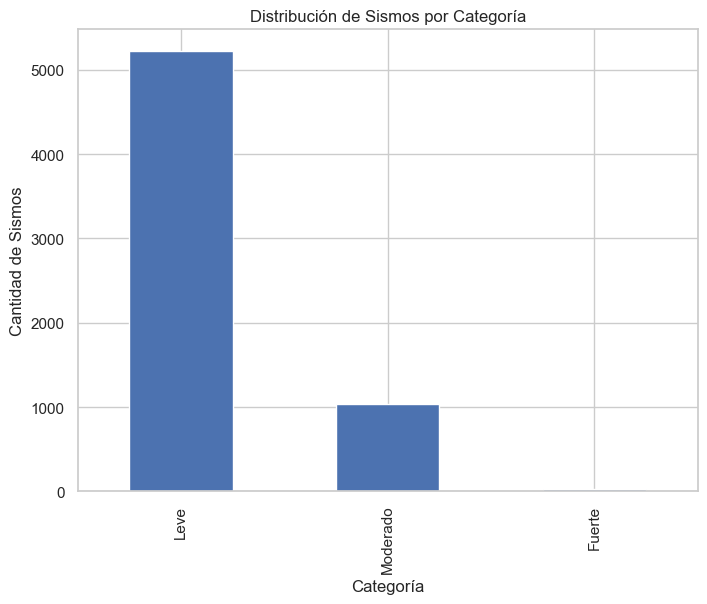

In [42]:
plt.figure(figsize=(8, 6))
bins = [-np.inf, 3.5, 5.0, np.inf]
labels = ['Leve', 'Moderado', 'Fuerte']
df['categoria'] = pd.cut(df['magnitud'], bins=bins, labels=labels)
conteos = df['categoria'].value_counts().reindex(labels)
conteos.plot(kind='bar')
plt.title('Distribución de Sismos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Sismos')
plt.show()


### 2. Top 10 regiones por cantidad de sismos

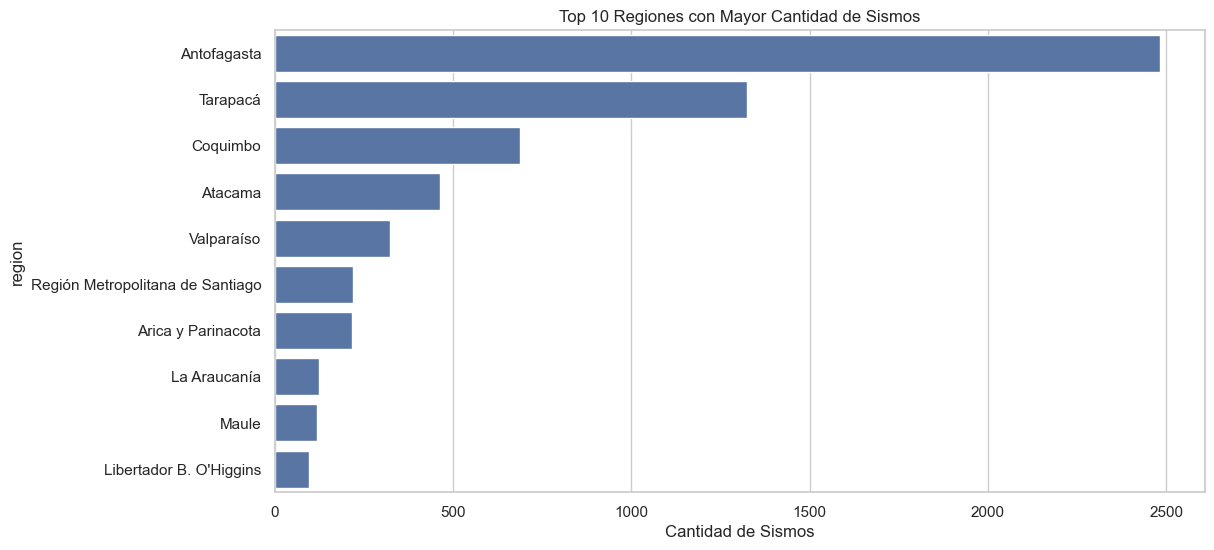

In [43]:
plt.figure(figsize=(12, 6))
top_10_regiones = df['region'].value_counts().head(10)
sns.barplot(x=top_10_regiones.values, y=top_10_regiones.index)
plt.title('Top 10 Regiones con Mayor Cantidad de Sismos')
plt.xlabel('Cantidad de Sismos')
plt.show()

### 3. Distribución de magnitudes (histograma)

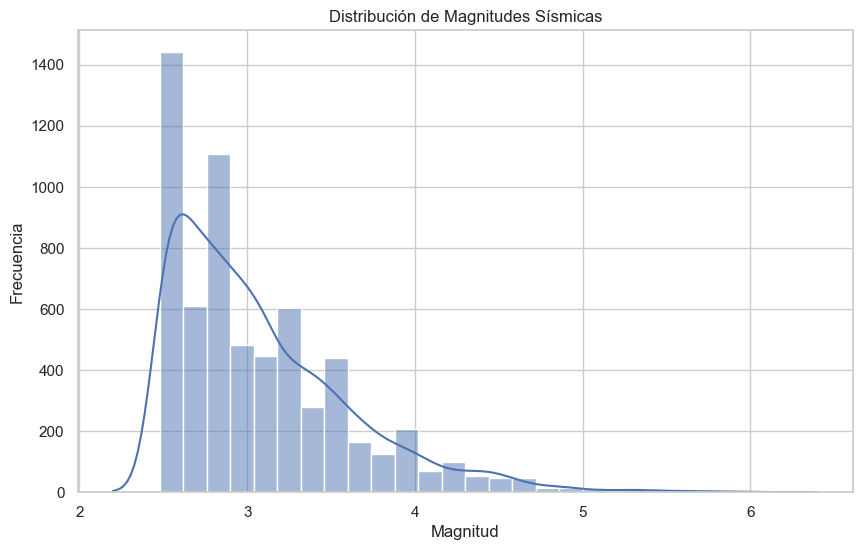

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='magnitud', bins=30, kde=True)
plt.title('Distribución de Magnitudes Sísmicas')
plt.xlabel('Magnitud')
plt.ylabel('Frecuencia')
plt.show()

### 4. Mapa de calor de sismos por región y categoría

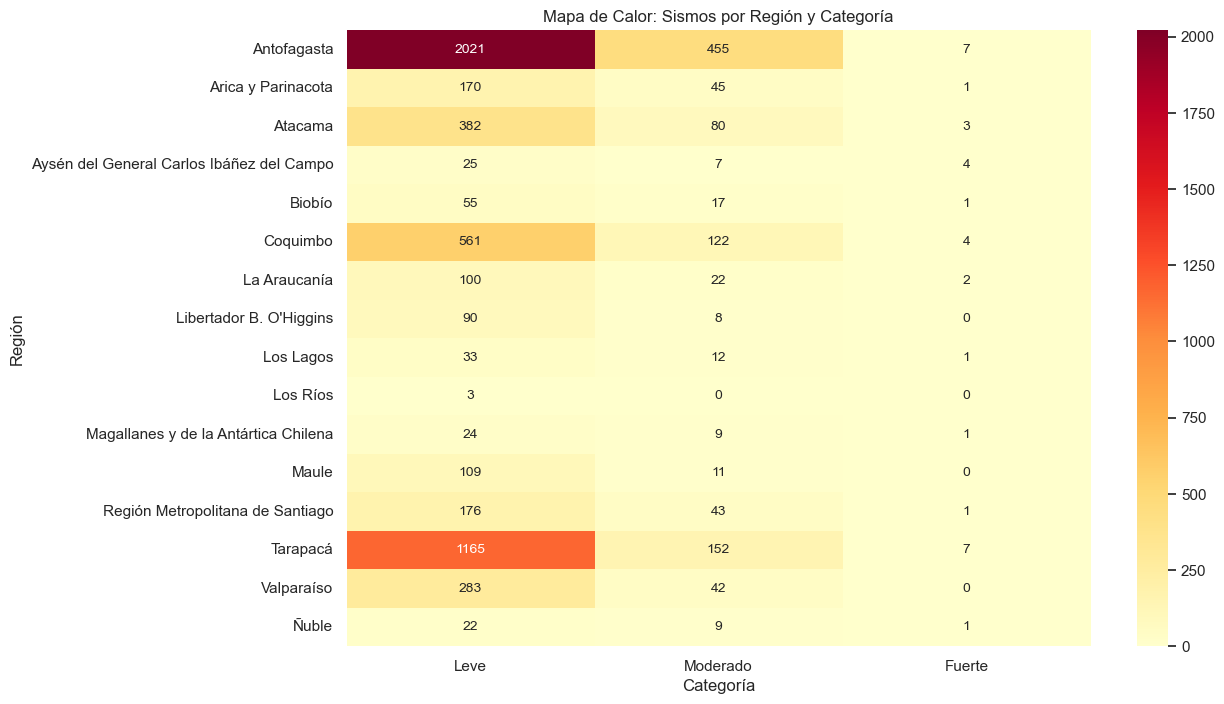

In [45]:
plt.figure(figsize=(12, 8))
pivot_table = pd.crosstab(df['region'], df['categoria'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Mapa de Calor: Sismos por Región y Categoría')
plt.ylabel('Región')
plt.xlabel('Categoría')
plt.show()

### 5. Mapa de calor: Sismos por categoria y Rango de Profundidad

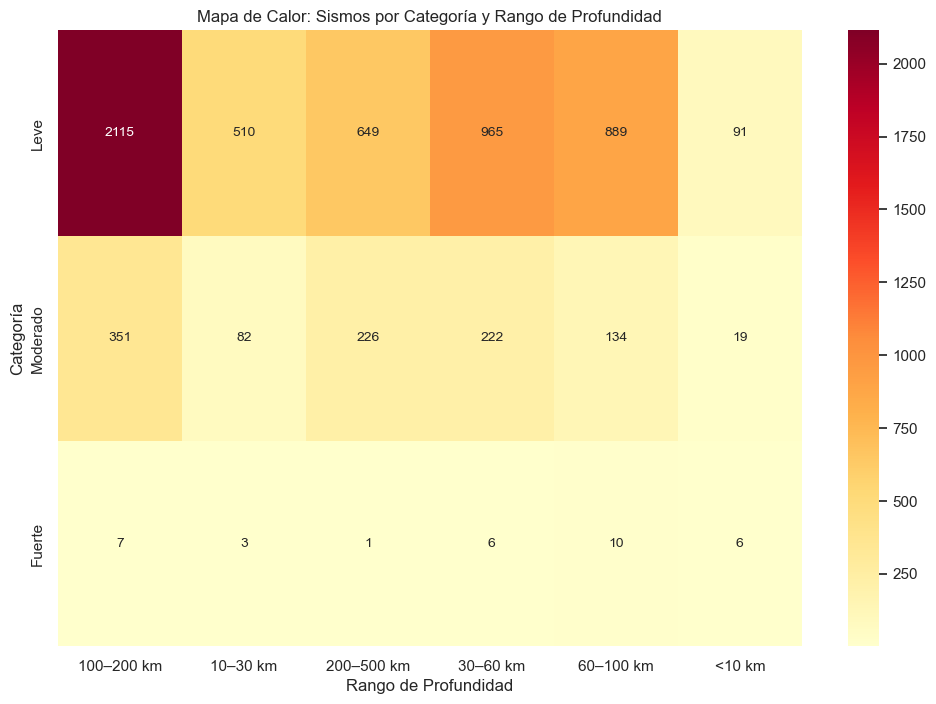

In [49]:

plt.figure(figsize=(12, 8))
pivot_table = pd.crosstab(df['categoria'], df['rango_profundidad'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Mapa de Calor: Sismos por Categoría y Rango de Profundidad')
plt.ylabel('Categoría')
plt.xlabel('Rango de Profundidad')
plt.show()

### 6. Box plot de magnitudes por región

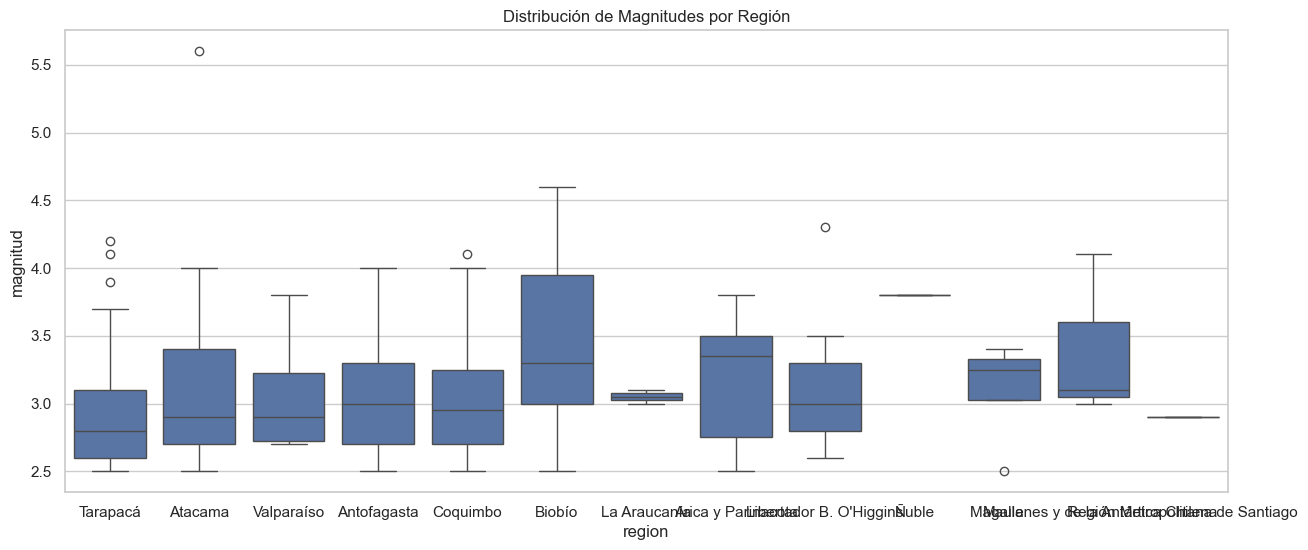

In [72]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='region', y='magnitud')
plt.title('Distribución de Magnitudes por Región')
plt.show()


# Parte 5: Algoritmos de clasificacion.

*El script realiza un proceso de Machine Learning para clasificación, utilizando la magnitud de un sismo ($\mathbf{X}$) para predecir su categoría ($\mathbf{y}$) mediante dos algoritmos: Regresión Logística y K-Nearest Neighbors (KNN).*

## Obtener los datos y entrenar los modelos

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Utilizar los datos ya procesados
X = df[['profundidad']]
y = df['categoria']

# Entrenar los modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regresión Logística
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)




## Mostrar los resultados de ambos modelos

In [70]:
metrics = {
    'Modelo': ['Regresión Logística', 'K-Nearest Neighbors (KNN)'],
    'Accuracy': [],
    'Precision (Avg)': [],
    'Recall (Avg)': [],
    'F1-Score (Avg)': []
}

# Regresión Logística
acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log, average='weighted', zero_division=0)
rec_log = recall_score(y_test, y_pred_log, average='weighted', zero_division=0)
f1_log = f1_score(y_test, y_pred_log, average='weighted', zero_division=0)

# KNN
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
rec_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

# Cargar los resultados
metrics['Accuracy'] = [acc_log, acc_knn]
metrics['Precision (Avg)'] = [prec_log, prec_knn]
metrics['Recall (Avg)'] = [rec_log, rec_knn]
metrics['F1-Score (Avg)'] = [f1_log, f1_knn]

# Crear el DataFrame con los resultados
results_df = pd.DataFrame(metrics)
print("Resultados de la Evaluación de Modelos:\n", results_df.to_string(index=False))


Resultados de la Evaluación de Modelos:
                    Modelo  Accuracy  Precision (Avg)  Recall (Avg)  F1-Score (Avg)
      Regresión Logística  0.833510         0.694739      0.833510        0.757824
K-Nearest Neighbors (KNN)  0.806469         0.725582      0.806469        0.756007


- Como podemos ver la precisón de ambos modelos es cercana al 80%, esto se mostrara mas claramente en la gráfica. Pero la explicacion técnica, es el desbalance entre las categorias.
- ¿Qué quiere decir esto?, quiere decir que las categorias tienen tal diferencia de cantidad de datos que los modelos de predicción son sesgados por estos datos y pierden precisión, por ejemplo.
El modelo de regresión logísitica presenta una precisión del 83%, esto porque como se vera a continuación, Siempre apuesta a que la categoria sera leve, esto por la distribución de los datos, acertara una 83% de los datos.
- En cambio el modelo KNN al decidir según los vecinos logra algunas predicciones "Moderadas", pero al hacerlo tambien pierde precisión ya que como se menciono la mayoria de datos se encuentran en "leve", es decir, predice mas variado pero se equivoca mas.

## Resultados de la Evaluación

### Predicción regresión logistica vs Valores reales

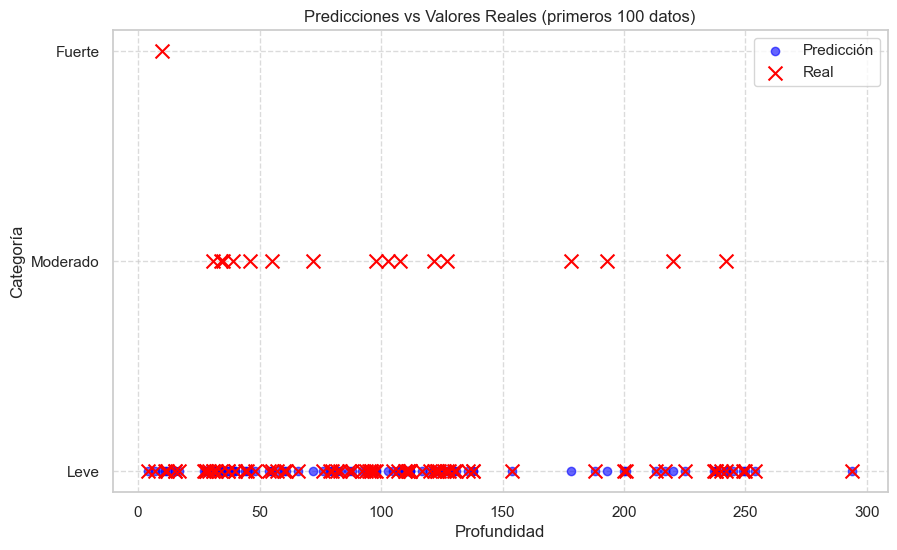

In [72]:
import matplotlib.pyplot as plt
N = 100
plt.figure(figsize=(10, 6))
plt.scatter(X_test['profundidad'].head(N), y_pred_log[:N], color='blue', label='Predicción', alpha=0.6)
plt.scatter(X_test['profundidad'].head(N), y_test.head(N), color='red', label='Real', marker='x', s=100)
plt.title(f'Predicciones vs Valores Reales (primeros {N} datos)')
plt.xlabel('Profundidad')
plt.ylabel('Categoría')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



- Aqui podemos ver como los puntos de predicción siempre estan en leve, ya que el modelo aprendio que si siempre dice leve, la probabilidad de acertar es alta. Por lo que no se arriesga y siempre dice leve, teniendo un 83% de precisión

### Predicción KNN vs valores reales

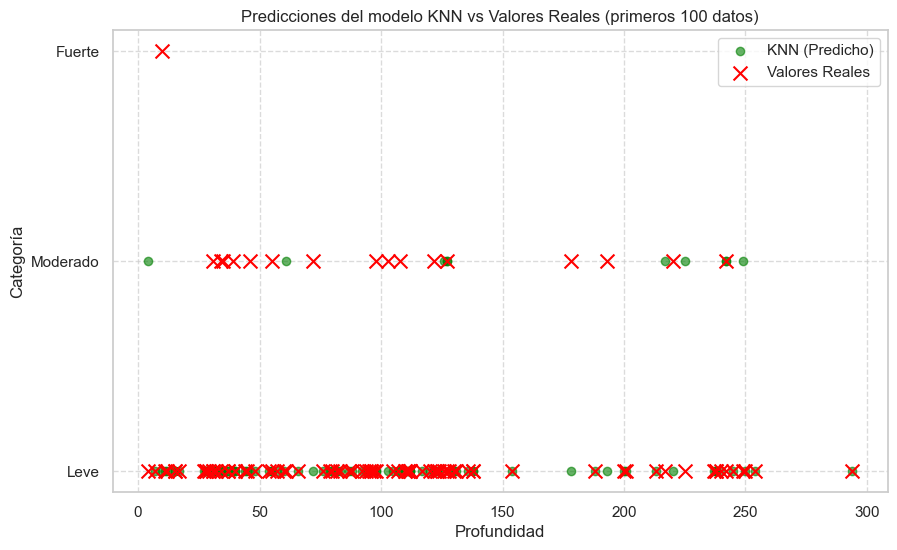

In [74]:
N = 100
plt.figure(figsize=(10, 6))
plt.scatter(X_test['profundidad'].head(N), y_pred_knn[:N], color='green', label='KNN (Predicho)', alpha=0.6)
plt.scatter(X_test['profundidad'].head(N), y_test.head(N), color='red', label='Valores Reales', marker='x', s=100)

plt.title(f'Predicciones del modelo KNN vs Valores Reales (primeros {N} datos)')
plt.xlabel('Profundidad')
plt.ylabel('Categoría')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
